# Обучение с учителем

Изучим отток клиентов (churn) для провайдера интерент услуг и телефонаии.
1. Проведем исследование данных (exploratory data analysis - EDA)
2. Когортный анализ оттока клиентов (churn cohort analysis). Когда клиент перестает пользоваться услугами компании.
3. Предиктивное машинное обучение. На основе признаков определим, что с высокой вероятностью клиент уйдет в отток.

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv(r"Telco-Customer-Churn.csv")

In [105]:
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


Наша целевая переменная - колонка Churn

Посмотрим на основные характеристики датафрейма. Проверим типы данных для колонок и наличие отсутствующих значений.

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


В датафрейме во всех колонках 7032 строки и нет отсутствующих значений. Большая часть колонок object, а значит нам нужно будет создать дамми переменные для текстовых значений.

Посмотрим на основные характеристики числовых колонок.

In [107]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


Колонка SeniorCitizen имеет значения от 0 до 1. Вероятно она принимает только 2 значения 0 и 1 - это категориальная переменная. А другие колонки имеют непрерывные значения. 

tenure - сколько месяцев человек является абонентомБ от 1 до 72. 

Убедимся, что в наших данных нет отсутствующих значений.

In [108]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Посмотрим на сбаллансированность целевой переменной Churn

<Axes: xlabel='Churn', ylabel='count'>

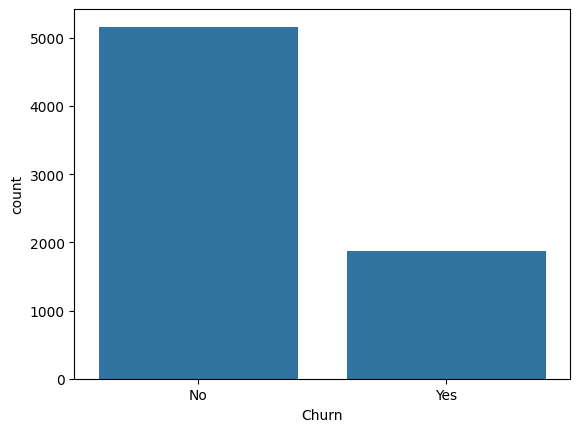

In [109]:
sns.countplot(data=df, x='Churn')

In [110]:
df['Churn'].value_counts()

Churn
No     5163
Yes    1869
Name: count, dtype: int64

Данные не сбаллансированы. Но это соотношение небольшое.

Посмотрим распределение данных в колонке TotalCharges по раздичных категориям Churn

<Axes: xlabel='Churn', ylabel='TotalCharges'>

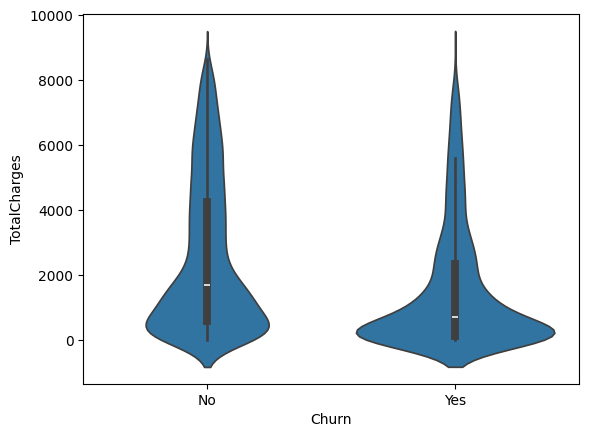

In [111]:
sns.violinplot(data=df, x='Churn', y='TotalCharges')

<Axes: xlabel='Churn', ylabel='TotalCharges'>

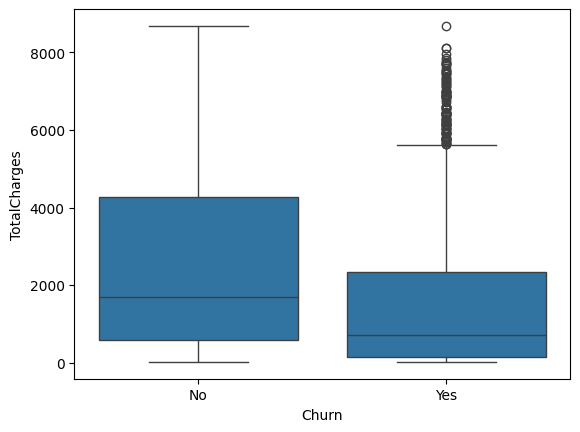

In [112]:
sns.boxplot(data=df, x='Churn', y='TotalCharges')

Построим график распределения колонки TotalCharges для различных типов контрактов. Раскрасим цвета по колонке Churn

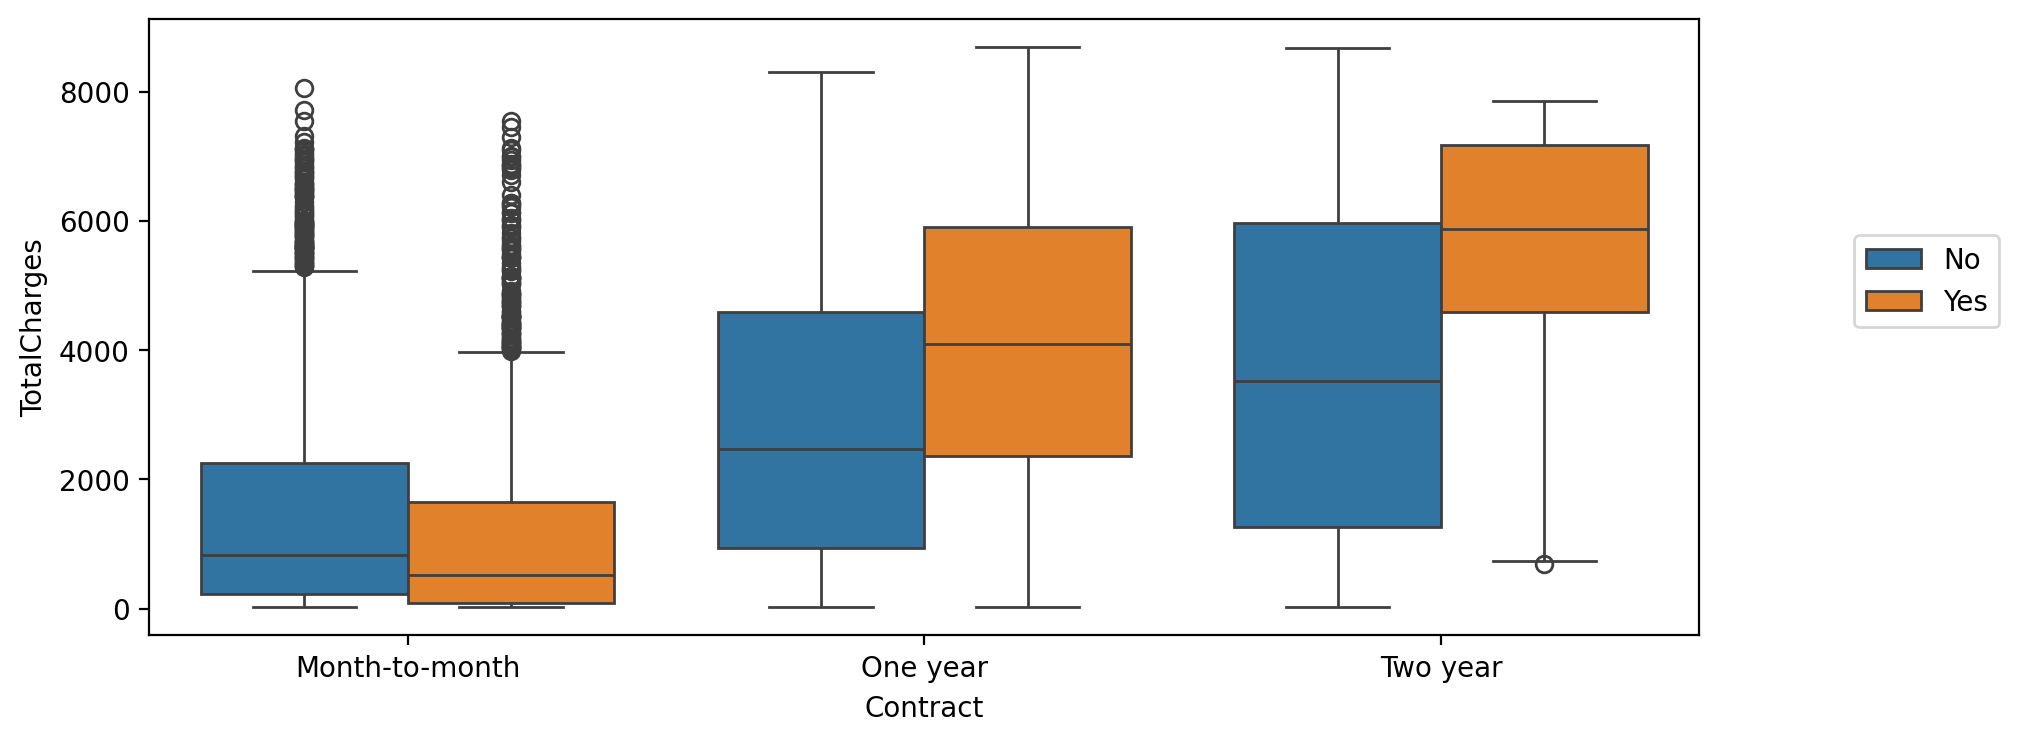

In [113]:
plt.figure(figsize=(10, 4), dpi=200)
sns.boxplot(data=df, y='TotalCharges', x='Contract', hue='Churn')
plt.legend(loc=(1.1, 0.5))

Если мы посмотрим на тип контракта Month-to-month, то количество Churn = Yes и Churn=No практически одинаково. Так же для типа контракта One year Contract. Для двухлетних контрактов мы видим меньшее количество людей, уходящих в отток.

Что может сделать компания для уменьшения оттока в месяц и в год? Для контрактов в месяц люди могли заранее решить, что будут пользрваться услушами не долго.

В годовых контрактах отток больше всего. Мы рассмтаривали колонку TotalCharges и можем сделать вывод, что в отток уходят те, кто платит больше, как и в двухлетнем варианте. Либо их не устраивает качество услуг, либо они уходят к конкурентам за более выгодными предложениями.

Построим график корреляции отдельных признаков с целевой переменной. для этого мы должны категориальные переменные преобразовать в дамми переменные.

In [114]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [115]:
pd.get_dummies(df[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'InternetService', 
                   'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']])

,SeniorCitizen,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
0,0,True,False,False,True,True,False,True,False,False,...,False,False,False,True,False,False,True,False,True,False
1,0,False,True,True,False,True,False,False,True,True,...,True,False,True,False,False,False,False,True,True,False
2,0,False,True,True,False,True,False,False,True,True,...,False,False,False,True,False,False,False,True,False,True
3,0,False,True,True,False,True,False,True,False,False,...,True,False,True,False,True,False,False,False,True,False
4,0,True,False,True,False,True,False,False,True,True,...,False,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0,False,True,False,True,False,True,False,True,False,...,True,False,False,True,False,False,False,True,True,False
7028,0,True,False,False,True,False,True,False,True,False,...,True,False,False,True,False,True,False,False,True,False
7029,0,True,False,False,True,False,True,True,False,False,...,False,False,False,True,False,False,True,False,True,False
7030,1,False,True,False,True,True,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True


Для графика и сравнения мы не будем удалять дублирующиеся колонки, которые образовались при преобразовании дамми переменных. Но в будущем мы их удалим drop_first = True, для избежания мультиколлениарности признаков.

Поскольку нам интересны данные оттока, мы можем оставить только Churn_Yes.

In [116]:
corr_df = pd.get_dummies(df[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'InternetService', 
                   'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']]).corr()

Выведем сортированные данные корреляции и удалим строки Churn_No и Churn_Yes. 

In [117]:
corr_df['Churn_Yes'].sort_values().iloc[1: -1]

Contract_Two year                         -0.301552
OnlineSecurity_No internet service        -0.227578
TechSupport_No internet service           -0.227578
InternetService_No                        -0.227578
OnlineBackup_No internet service          -0.227578
StreamingMovies_No internet service       -0.227578
StreamingTV_No internet service           -0.227578
DeviceProtection_No internet service      -0.227578
PaperlessBilling_No                       -0.191454
Contract_One year                         -0.178225
OnlineSecurity_Yes                        -0.171270
TechSupport_Yes                           -0.164716
Dependents_Yes                            -0.163128
Partner_Yes                               -0.149982
PaymentMethod_Credit card (automatic)     -0.134687
InternetService_DSL                       -0.124141
PaymentMethod_Bank transfer (automatic)   -0.118136
PaymentMethod_Mailed check                -0.090773
OnlineBackup_Yes                          -0.082307
DeviceProtec

In [118]:
corr_yes_churn = corr_df['Churn_Yes'].sort_values().iloc[1: -1]

Визуализируем данные

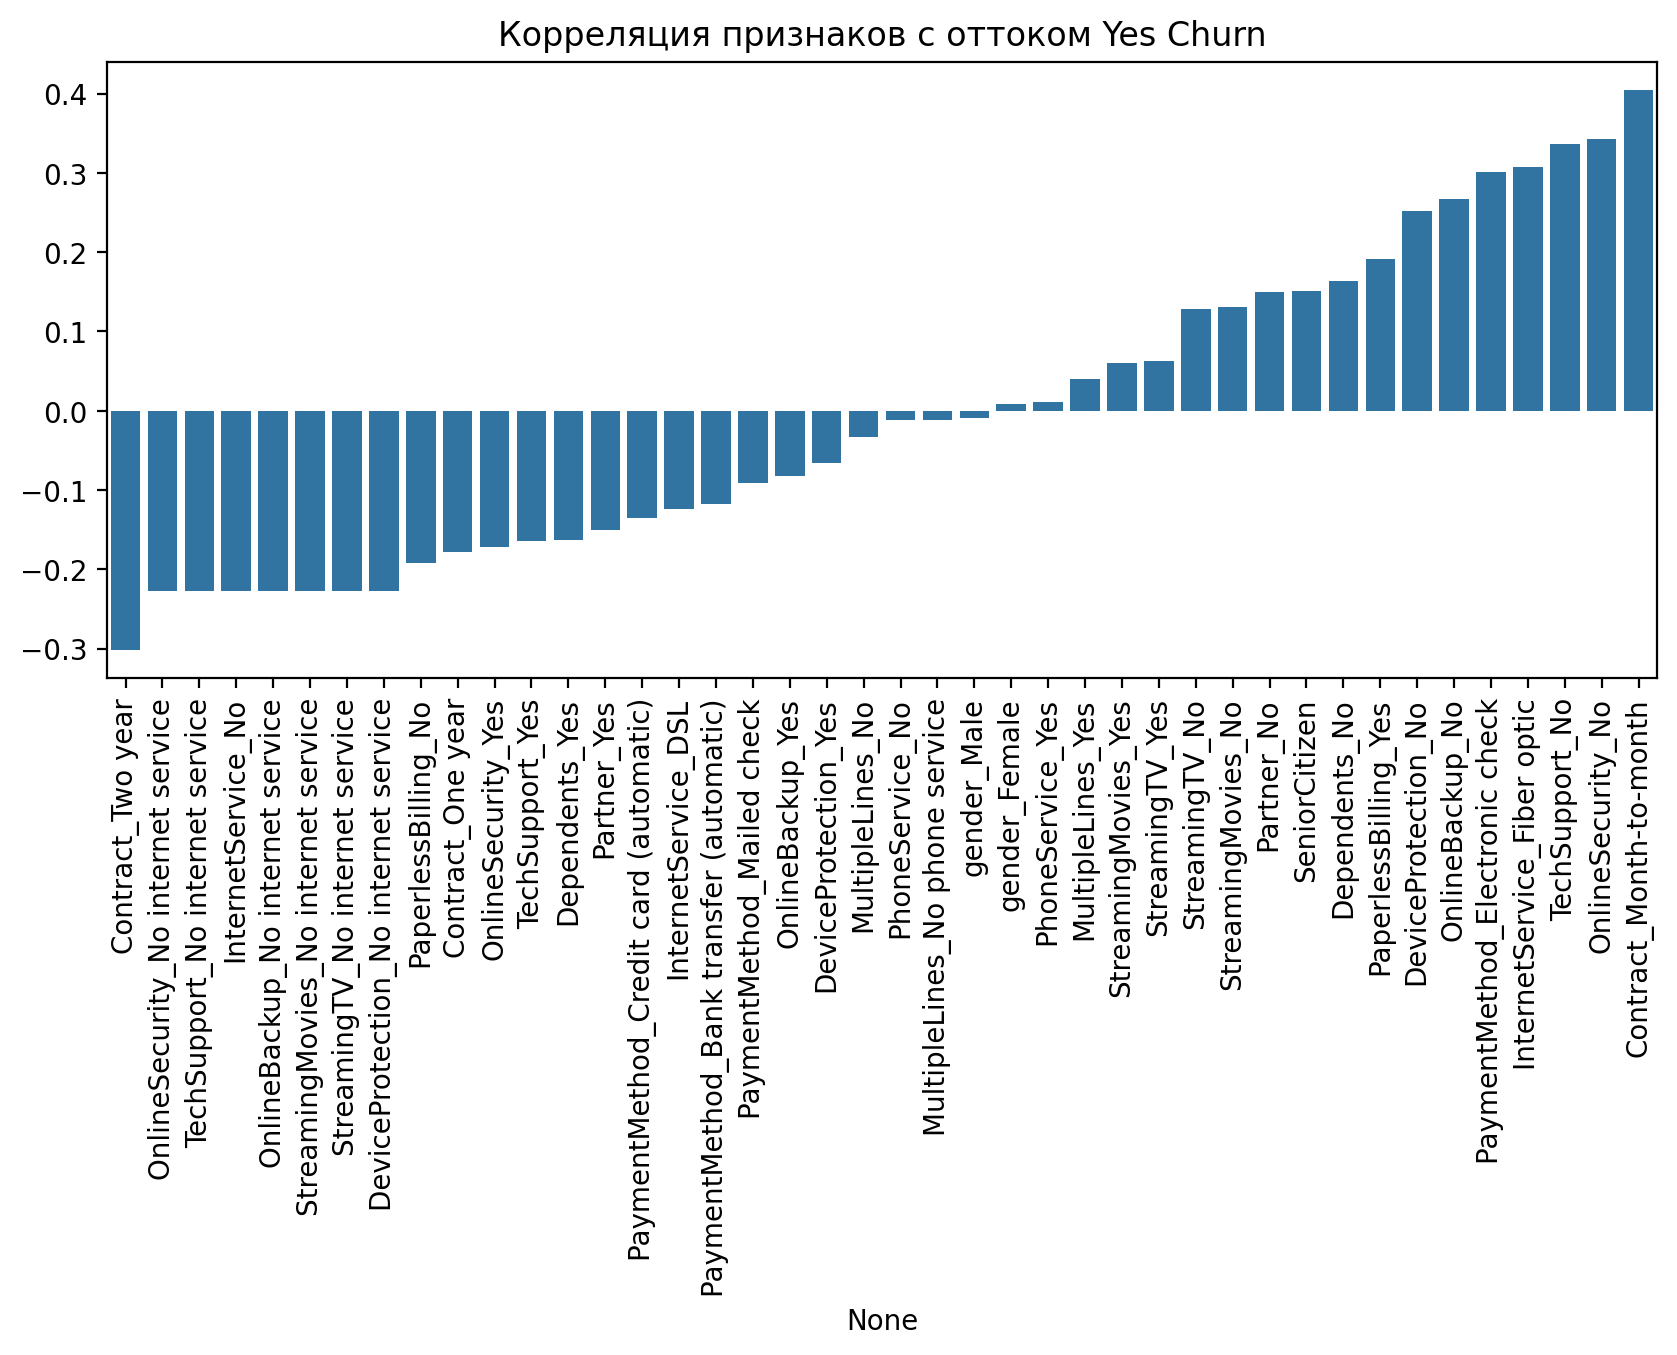

In [119]:
plt.figure(figsize=(10, 4), dpi=200)
plt.title('Корреляция признаков с оттоком Yes Churn')
sns.barplot(x=corr_yes_churn.index, y=corr_yes_churn.values)
plt.xticks(rotation=90);

**Проведем когортный анализ и анализ оттока**

Разобьем всех абонентов на сегменты по длительности обслуживания, что бы понять поведение абонента в зависимости от длительности обслуживания. 

Создадим гистограмму с распределением значений колонки tenure - это количество месяцев, сколько времени человек являлся или является абонентом компании. 

In [120]:
df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [121]:
# Посмотрим, сколько месяцев человек является абонентом компании
df['tenure'].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26, 39])

<Axes: xlabel='tenure', ylabel='Count'>

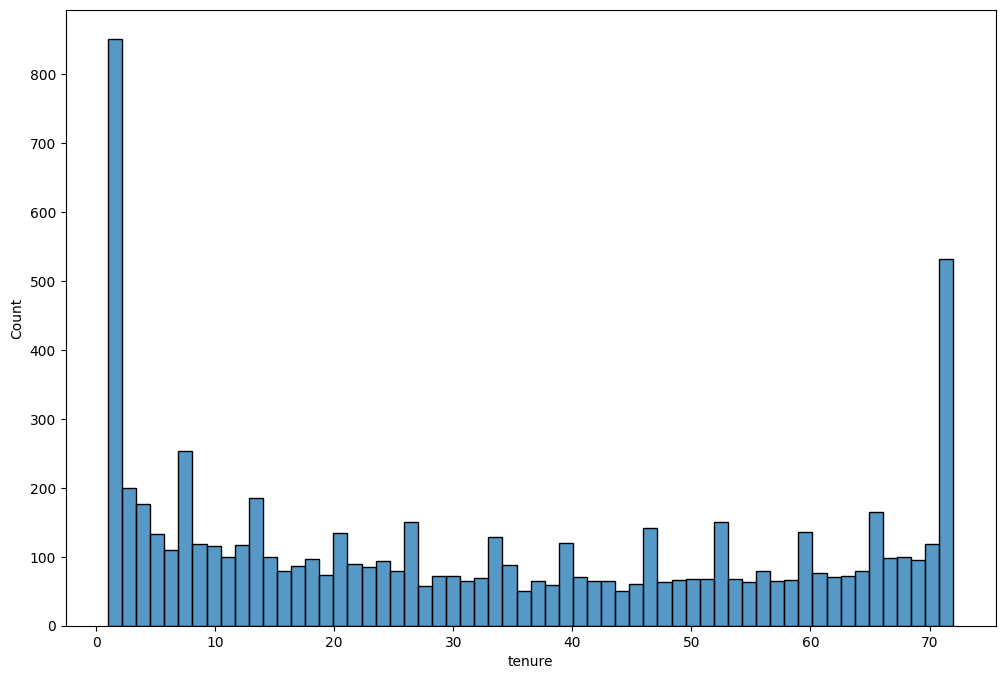

In [122]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='tenure', bins=60)

Проанализируем распределение данных в разрезе типов контрактов и оттока

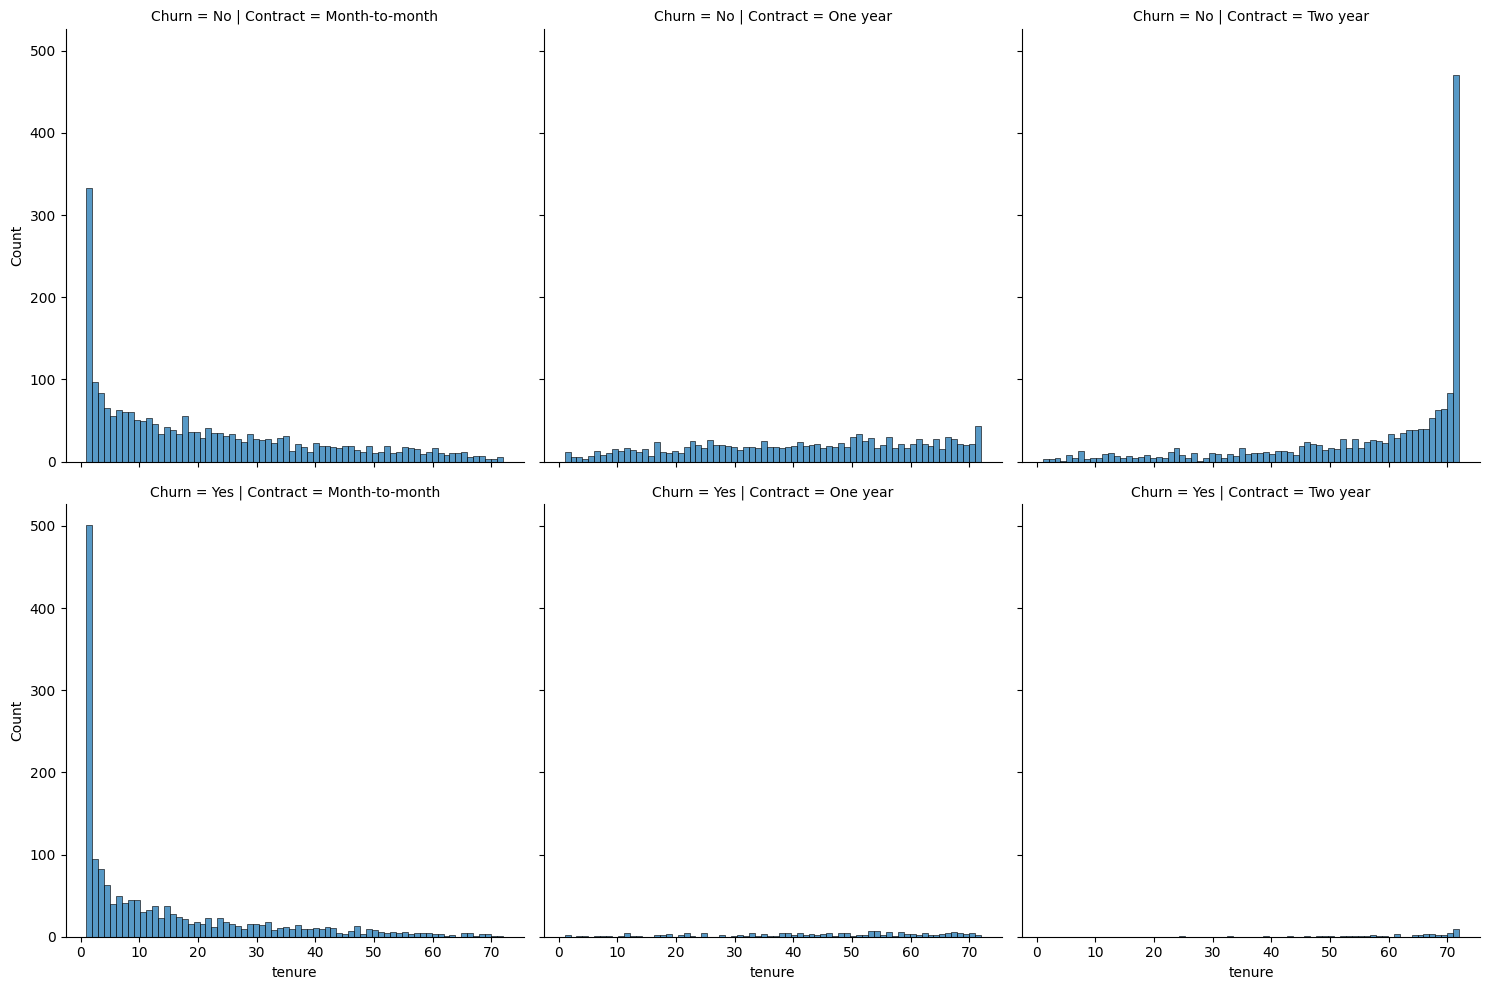

In [123]:
sns.displot(data=df, x='tenure', bins=70, col='Contract', row='Churn')

Мы видим, что наибольший отток находится в колонке Month-to-month.

Построим график для колонок Total Charges и Monthly Charges. Раскрасим график цветом по колонке Churn

<Axes: xlabel='MonthlyCharges', ylabel='TotalCharges'>

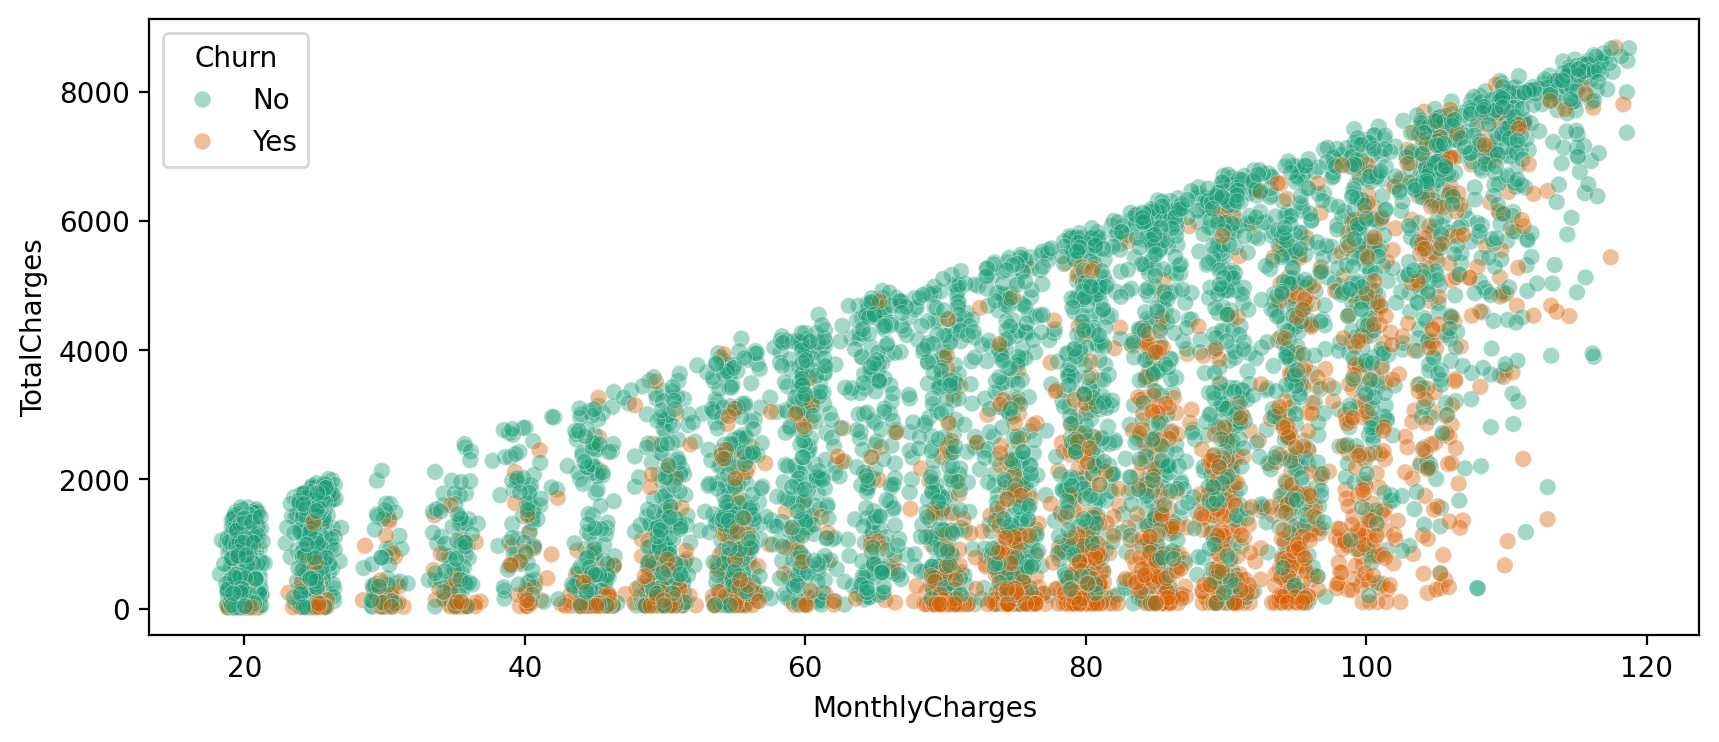

In [124]:
plt.figure(figsize=(10, 4), dpi=200)
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='Churn', 
                alpha=0.4, lw=0.3, palette='Dark2')

мы видим, что в отток уходят те, у кого больше ежемесяцные расходы

**Создадим когорты (сегменты) по колонке Tenure**

Поместим различные значения Tenure (1 месяц, 2 месяца и т.д.) в отдельные когорты (сегменты). Затем для каждого уникального значения колонки Tenure вычислим проценты оттока от общего количества людей в данной когорте. 

In [125]:
# Посмотрим отдельно тех, кто ушел в отток
df.groupby(['Churn', 'tenure']).count()

customerID  gender  SeniorCitizen  Partner  Dependents  \
Churn tenure                                                           
No    1              233     233            233      233         233   
      2              115     115            115      115         115   
      3              106     106            106      106         106   
      4               93      93             93       93          93   
      5               69      69             69       69          69   
...                  ...     ...            ...      ...         ...   
Yes   68               9       9              9        9           9   
      69               8       8              8        8           8   
      70              11      11             11       11          11   
      71               6       6              6        6           6   
      72               6       6              6        6           6   

              PhoneService  MultipleLines  InternetService  OnlineSecurity  \
Churn tenure                                                                 
No    1                233            233              233             233   
      2                115            115              115             115   
      3                106            106              106             106   
      4                 93             93               93              93   
      5                 69             69               69              69   
...                    ...            ...              ...             ...   
Yes   68                 9              9                9               9   
      69                 8              8                8               8   
      70                11             11               11              11   
      71                 6              6                6               6   
      72                 6              6                6               6   

              OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
Churn tenure                                                             
No    1                233               233          233          233   
      2                115               115          115          115   
      3                106               106          106          106   
      4                 93                93           93           93   
      5                 69                69           69           69   
...                    ...               ...          ...          ...   
Yes   68                 9                 9            9            9   
      69                 8                 8            8            8   
      70                11                11           11           11   
      71                 6                 6            6            6   
      72                 6                 6            6            6   

              StreamingMovies  Contract  PaperlessBilling  PaymentMethod  \
Churn tenure                                                               
No    1                   233       233               233            233   
      2                   115       115               115            115   
      3                   106       106               106            106   
      4                    93        93                93             93   
      5                    69        69                69             69   
...                       ...       ...               ...            ...   
Yes   68                    9         9                 9              9   
      69                    8         8                 8              8   
      70                   11        11                11             11   
      71                    6         6                 6              6   
      72                    6         6                 6              6   

              MonthlyCharges  TotalCharges  
Churn tenure                                
No    1             

In [126]:
df.groupby(['Churn', 'tenure']).count().transpose()['Yes']

tenure,1,2,3,4,5,6,7,8,9,10,...,63,64,65,66,67,68,69,70,71,72
customerID,380,123,94,83,64,40,51,42,46,45,...,4,4,9,13,10,9,8,11,6,6
gender,380,123,94,83,64,40,51,42,46,45,...,4,4,9,13,10,9,8,11,6,6
SeniorCitizen,380,123,94,83,64,40,51,42,46,45,...,4,4,9,13,10,9,8,11,6,6
Partner,380,123,94,83,64,40,51,42,46,45,...,4,4,9,13,10,9,8,11,6,6
Dependents,380,123,94,83,64,40,51,42,46,45,...,4,4,9,13,10,9,8,11,6,6
PhoneService,380,123,94,83,64,40,51,42,46,45,...,4,4,9,13,10,9,8,11,6,6
MultipleLines,380,123,94,83,64,40,51,42,46,45,...,4,4,9,13,10,9,8,11,6,6
InternetService,380,123,94,83,64,40,51,42,46,45,...,4,4,9,13,10,9,8,11,6,6
OnlineSecurity,380,123,94,83,64,40,51,42,46,45,...,4,4,9,13,10,9,8,11,6,6
OnlineBackup,380,123,94,83,64,40,51,42,46,45,...,4,4,9,13,10,9,8,11,6,6


In [127]:
yes_churn = df.groupby(['Churn', 'tenure']).count().transpose()['Yes']

In [128]:
# Посмотрим отдельно тех, кто Не ушел в отток
df.groupby(['Churn', 'tenure']).count().transpose()['No']

tenure,1,2,3,4,5,6,7,8,9,10,...,63,64,65,66,67,68,69,70,71,72
customerID,233,115,106,93,69,70,80,81,73,71,...,68,76,67,76,88,91,87,108,164,356
gender,233,115,106,93,69,70,80,81,73,71,...,68,76,67,76,88,91,87,108,164,356
SeniorCitizen,233,115,106,93,69,70,80,81,73,71,...,68,76,67,76,88,91,87,108,164,356
Partner,233,115,106,93,69,70,80,81,73,71,...,68,76,67,76,88,91,87,108,164,356
Dependents,233,115,106,93,69,70,80,81,73,71,...,68,76,67,76,88,91,87,108,164,356
PhoneService,233,115,106,93,69,70,80,81,73,71,...,68,76,67,76,88,91,87,108,164,356
MultipleLines,233,115,106,93,69,70,80,81,73,71,...,68,76,67,76,88,91,87,108,164,356
InternetService,233,115,106,93,69,70,80,81,73,71,...,68,76,67,76,88,91,87,108,164,356
OnlineSecurity,233,115,106,93,69,70,80,81,73,71,...,68,76,67,76,88,91,87,108,164,356
OnlineBackup,233,115,106,93,69,70,80,81,73,71,...,68,76,67,76,88,91,87,108,164,356


In [129]:
no_churn = df.groupby(['Churn', 'tenure']).count().transpose()['No']

Посчитаем проценты

In [130]:
churn_rate = 100 * yes_churn / (no_churn + yes_churn)

In [131]:
churn_rate

tenure,1,2,3,4,5,6,7,8,9,10,...,63,64,65,66,67,68,69,70,71,72
customerID,61.990212,51.680672,47.0,47.159091,48.120301,36.363636,38.931298,34.146341,38.655462,38.793103,...,5.555556,5.0,11.842105,14.606742,10.204082,9.0,8.421053,9.243697,3.529412,1.657459
gender,61.990212,51.680672,47.0,47.159091,48.120301,36.363636,38.931298,34.146341,38.655462,38.793103,...,5.555556,5.0,11.842105,14.606742,10.204082,9.0,8.421053,9.243697,3.529412,1.657459
SeniorCitizen,61.990212,51.680672,47.0,47.159091,48.120301,36.363636,38.931298,34.146341,38.655462,38.793103,...,5.555556,5.0,11.842105,14.606742,10.204082,9.0,8.421053,9.243697,3.529412,1.657459
Partner,61.990212,51.680672,47.0,47.159091,48.120301,36.363636,38.931298,34.146341,38.655462,38.793103,...,5.555556,5.0,11.842105,14.606742,10.204082,9.0,8.421053,9.243697,3.529412,1.657459
Dependents,61.990212,51.680672,47.0,47.159091,48.120301,36.363636,38.931298,34.146341,38.655462,38.793103,...,5.555556,5.0,11.842105,14.606742,10.204082,9.0,8.421053,9.243697,3.529412,1.657459
PhoneService,61.990212,51.680672,47.0,47.159091,48.120301,36.363636,38.931298,34.146341,38.655462,38.793103,...,5.555556,5.0,11.842105,14.606742,10.204082,9.0,8.421053,9.243697,3.529412,1.657459
MultipleLines,61.990212,51.680672,47.0,47.159091,48.120301,36.363636,38.931298,34.146341,38.655462,38.793103,...,5.555556,5.0,11.842105,14.606742,10.204082,9.0,8.421053,9.243697,3.529412,1.657459
InternetService,61.990212,51.680672,47.0,47.159091,48.120301,36.363636,38.931298,34.146341,38.655462,38.793103,...,5.555556,5.0,11.842105,14.606742,10.204082,9.0,8.421053,9.243697,3.529412,1.657459
OnlineSecurity,61.990212,51.680672,47.0,47.159091,48.120301,36.363636,38.931298,34.146341,38.655462,38.793103,...,5.555556,5.0,11.842105,14.606742,10.204082,9.0,8.421053,9.243697,3.529412,1.657459
OnlineBackup,61.990212,51.680672,47.0,47.159091,48.120301,36.363636,38.931298,34.146341,38.655462,38.793103,...,5.555556,5.0,11.842105,14.606742,10.204082,9.0,8.421053,9.243697,3.529412,1.657459


In [132]:
churn_rate.transpose()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
tenure,,,,,,,,,,,,,,,,,,,
1,61.990212,61.990212,61.990212,61.990212,61.990212,61.990212,61.990212,61.990212,61.990212,61.990212,61.990212,61.990212,61.990212,61.990212,61.990212,61.990212,61.990212,61.990212,61.990212
2,51.680672,51.680672,51.680672,51.680672,51.680672,51.680672,51.680672,51.680672,51.680672,51.680672,51.680672,51.680672,51.680672,51.680672,51.680672,51.680672,51.680672,51.680672,51.680672
3,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
4,47.159091,47.159091,47.159091,47.159091,47.159091,47.159091,47.159091,47.159091,47.159091,47.159091,47.159091,47.159091,47.159091,47.159091,47.159091,47.159091,47.159091,47.159091,47.159091
5,48.120301,48.120301,48.120301,48.120301,48.120301,48.120301,48.120301,48.120301,48.120301,48.120301,48.120301,48.120301,48.120301,48.120301,48.120301,48.120301,48.120301,48.120301,48.120301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
69,8.421053,8.421053,8.421053,8.421053,8.421053,8.421053,8.421053,8.421053,8.421053,8.421053,8.421053,8.421053,8.421053,8.421053,8.421053,8.421053,8.421053,8.421053,8.421053
70,9.243697,9.243697,9.243697,9.243697,9.243697,9.243697,9.243697,9.243697,9.243697,9.243697,9.243697,9.243697,9.243697,9.243697,9.243697,9.243697,9.243697,9.243697,9.243697


Посмотрим проценты оттока по колонке пользователей по месяцам

In [133]:
churn_rate.transpose()['customerID']

tenure
1     61.990212
2     51.680672
3     47.000000
4     47.159091
5     48.120301
        ...    
68     9.000000
69     8.421053
70     9.243697
71     3.529412
72     1.657459
Name: customerID, Length: 72, dtype: float64

Визуалищируем данные

<Axes: xlabel='tenure'>

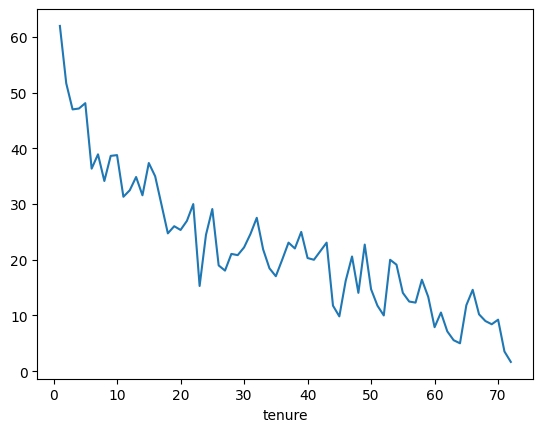

In [134]:
churn_rate.transpose()['customerID'].plot()

На основе данных tenure создадим новую колонку для категорий от 0 до 12 месяцев, от 12 до 24 месяцнв, от 24 до 48 меясцев и более 48 месяцев.

Создадим функцию:

In [135]:
def cohort(tenure):
    if tenure <= 12:
        return '0-12 месяцев'
    elif tenure <= 24:
        return '12-24 месяцев'
    elif tenure <= 48:
        return '24-48 месяцев'
    else:
        return 'больше 48 месяцев'

In [136]:
df['tenure'].apply(cohort)

0            0-12 месяцев
1           24-48 месяцев
2            0-12 месяцев
3           24-48 месяцев
4            0-12 месяцев
              ...        
7027        12-24 месяцев
7028    больше 48 месяцев
7029         0-12 месяцев
7030         0-12 месяцев
7031    больше 48 месяцев
Name: tenure, Length: 7032, dtype: object

In [137]:
df['Tenure cohort'] = df['tenure'].apply(cohort)

Изучим полученные данные 

In [138]:
df[['Tenure cohort', 'tenure']]

,Tenure cohort,tenure
0,0-12 месяцев,1
1,24-48 месяцев,34
2,0-12 месяцев,2
3,24-48 месяцев,45
4,0-12 месяцев,2
...,...,...
7027,12-24 месяцев,24
7028,больше 48 месяцев,72
7029,0-12 месяцев,11
7030,0-12 месяцев,4


<Axes: xlabel='MonthlyCharges', ylabel='TotalCharges'>

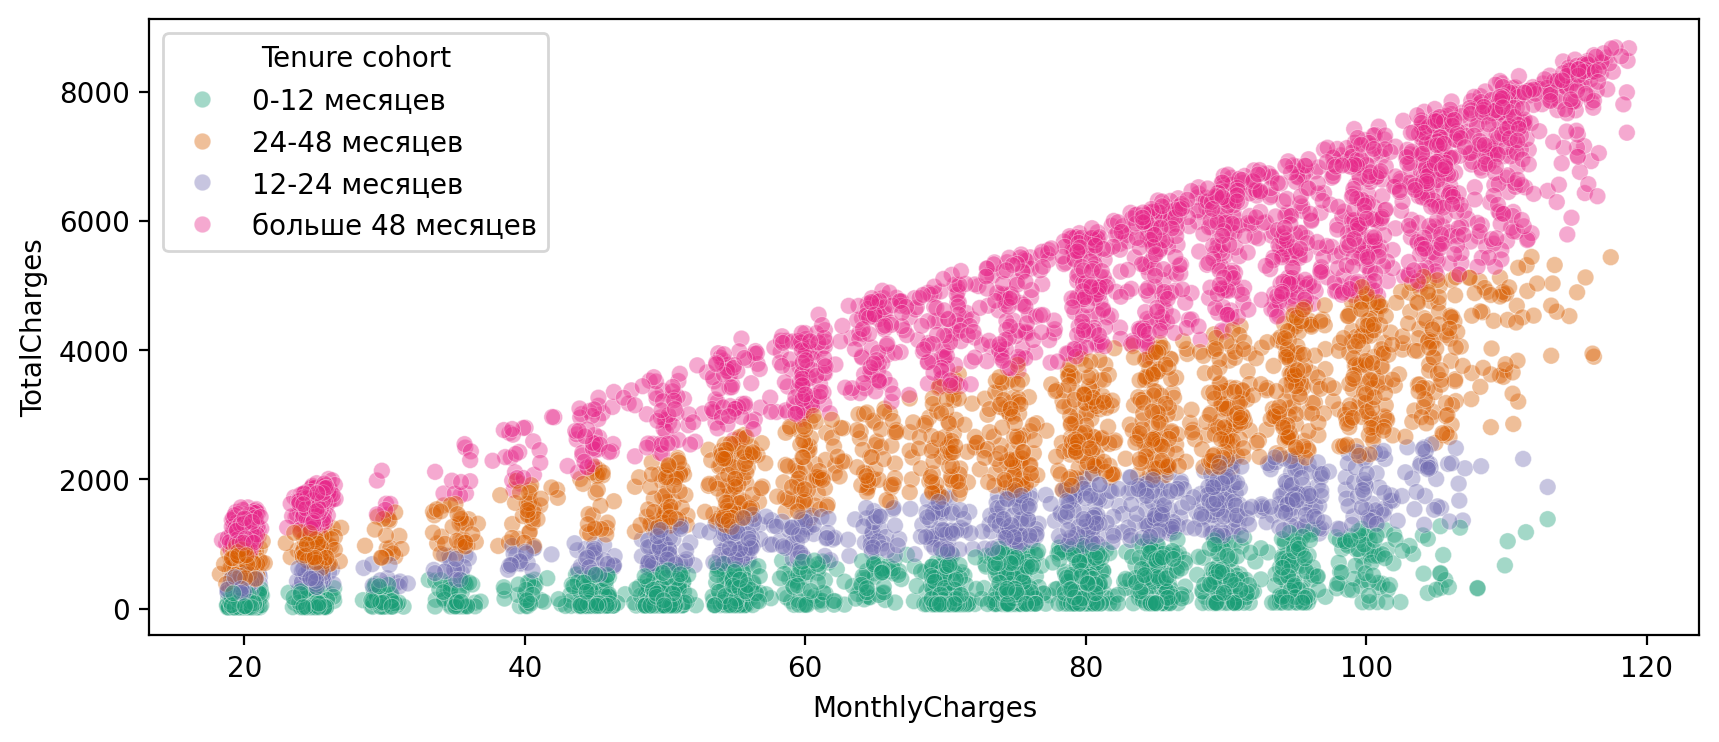

In [139]:
plt.figure(figsize=(10, 4), dpi=200)
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='Tenure cohort', 
                alpha=0.4, lw=0.3, palette='Dark2')

Чем дольше человек абонент компании, тем больше его траты.

Посчитаем отток для отдельных когорт

<Axes: xlabel='Tenure cohort', ylabel='count'>

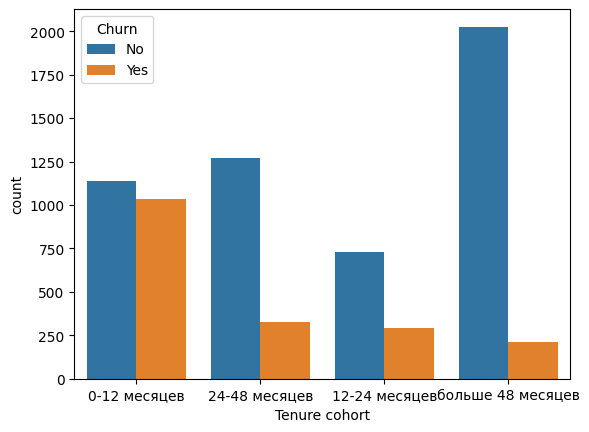

In [140]:
sns.countplot(data=df, x='Tenure cohort', hue='Churn')

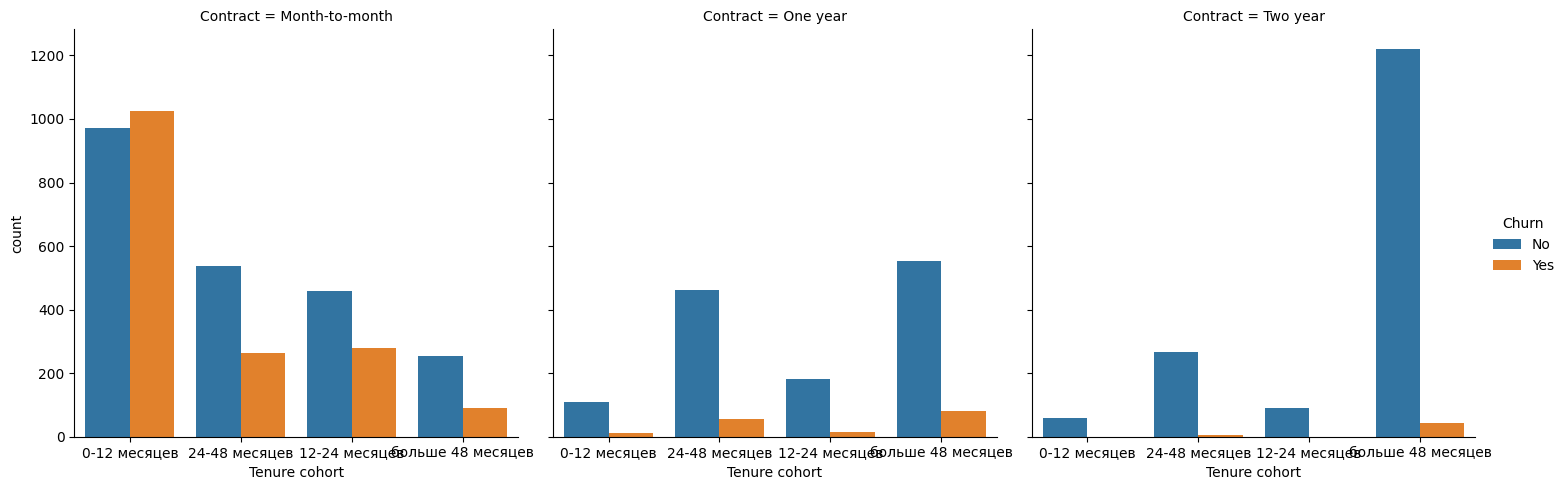

In [141]:
sns.catplot(data=df, x='Tenure cohort', hue='Churn', kind='count', col='Contract')

Наиболее меньший отток у контрактов 1 год и более.

# Далее мы исследуем 4 модели на основе деревьев: одно дерево решений, случайный лес, адаптивный бустинг и градиентный бустинг.

**Decision Tree (дерево решений)**

In [142]:
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Tenure cohort
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-12 месяцев
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,24-48 месяцев
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-12 месяцев


Поскольку в датасете имеются текстовые данные, преобразуем их в дамми переменные. Сперва разделим данные на признаки и целевую переменную. Колонка CustomerID является первичным ключём и содержить уникальные значения и фактически дублирует колонку Index. Удалим ее.

In [143]:
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

In [144]:
X = pd.get_dummies(X, drop_first=True)  # удалим дублирующие колонки

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

Далее создадим и обучим моедель дерева решений, оценим метрики, посмотрим на важность признаков, нарисуем график дерева.

In [146]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [147]:
dt = DecisionTreeClassifier(max_depth=6)

In [ ]:
dt.fit(X_train, y_train)

In [149]:
preds = dt.predict(X_test)

In [150]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

          No       0.87      0.89      0.88       557
         Yes       0.55      0.49      0.52       147

    accuracy                           0.81       704
   macro avg       0.71      0.69      0.70       704
weighted avg       0.80      0.81      0.81       704



Наша модель работает заметно лучше для класса No_churn (recall = 0,89), чем для класса Yes_churn (recall = 0,49). Данные не сбаллансированы - No_churn имеет больше данных, чем Yes_churn. Тем не менее результаты не хорошие.

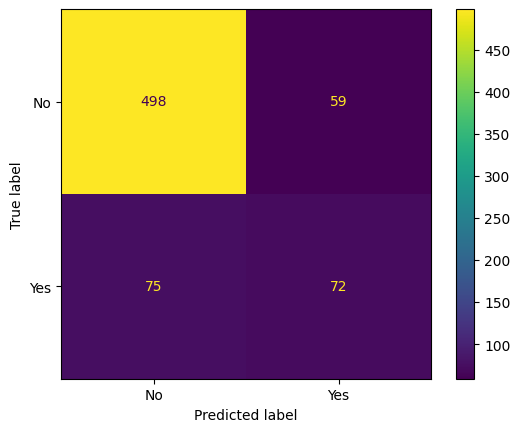

In [151]:
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)
plt.show()

Неправильно классифицировано 75 абонентов (они уходят в отток, но модель считает, что нет).И 59 абонентов не ходят, а модель считает, что уходят с отток. При этом, наиболее важно минимизировать тех, кого модель ошибочно считает оставшимися, а аони на самом деле ушли в отток (75).

Посмотрим на наиболее важные признаки

In [152]:
imp_feats = pd.DataFrame(data=dt.feature_importances_, index=X.columns, columns=['важность'])

In [153]:
imp_feats = imp_feats.sort_values('важность')

In [154]:
imp_feats

,важность
Dependents_Yes,0.000000
Partner_Yes,0.000000
OnlineSecurity_No internet service,0.000000
InternetService_No,0.000000
PaymentMethod_Mailed check,0.000000
Tenure cohort_12-24 месяцев,0.000000
PaperlessBilling_Yes,0.000000
Tenure cohort_24-48 месяцев,0.000000
PaymentMethod_Credit card (automatic),0.000000
StreamingMovies_Yes,0.000000


Уберем нули

In [155]:
imp_feats = imp_feats[imp_feats['важность'] > 0]

In [156]:
imp_feats

,важность
PhoneService_Yes,0.000890
gender_Male,0.001237
OnlineBackup_Yes,0.005341
MultipleLines_No phone service,0.006962
TechSupport_Yes,0.007868
OnlineSecurity_Yes,0.008376
Contract_One year,0.010021
SeniorCitizen,0.010825
MultipleLines_Yes,0.012432
OnlineBackup_No internet service,0.026290


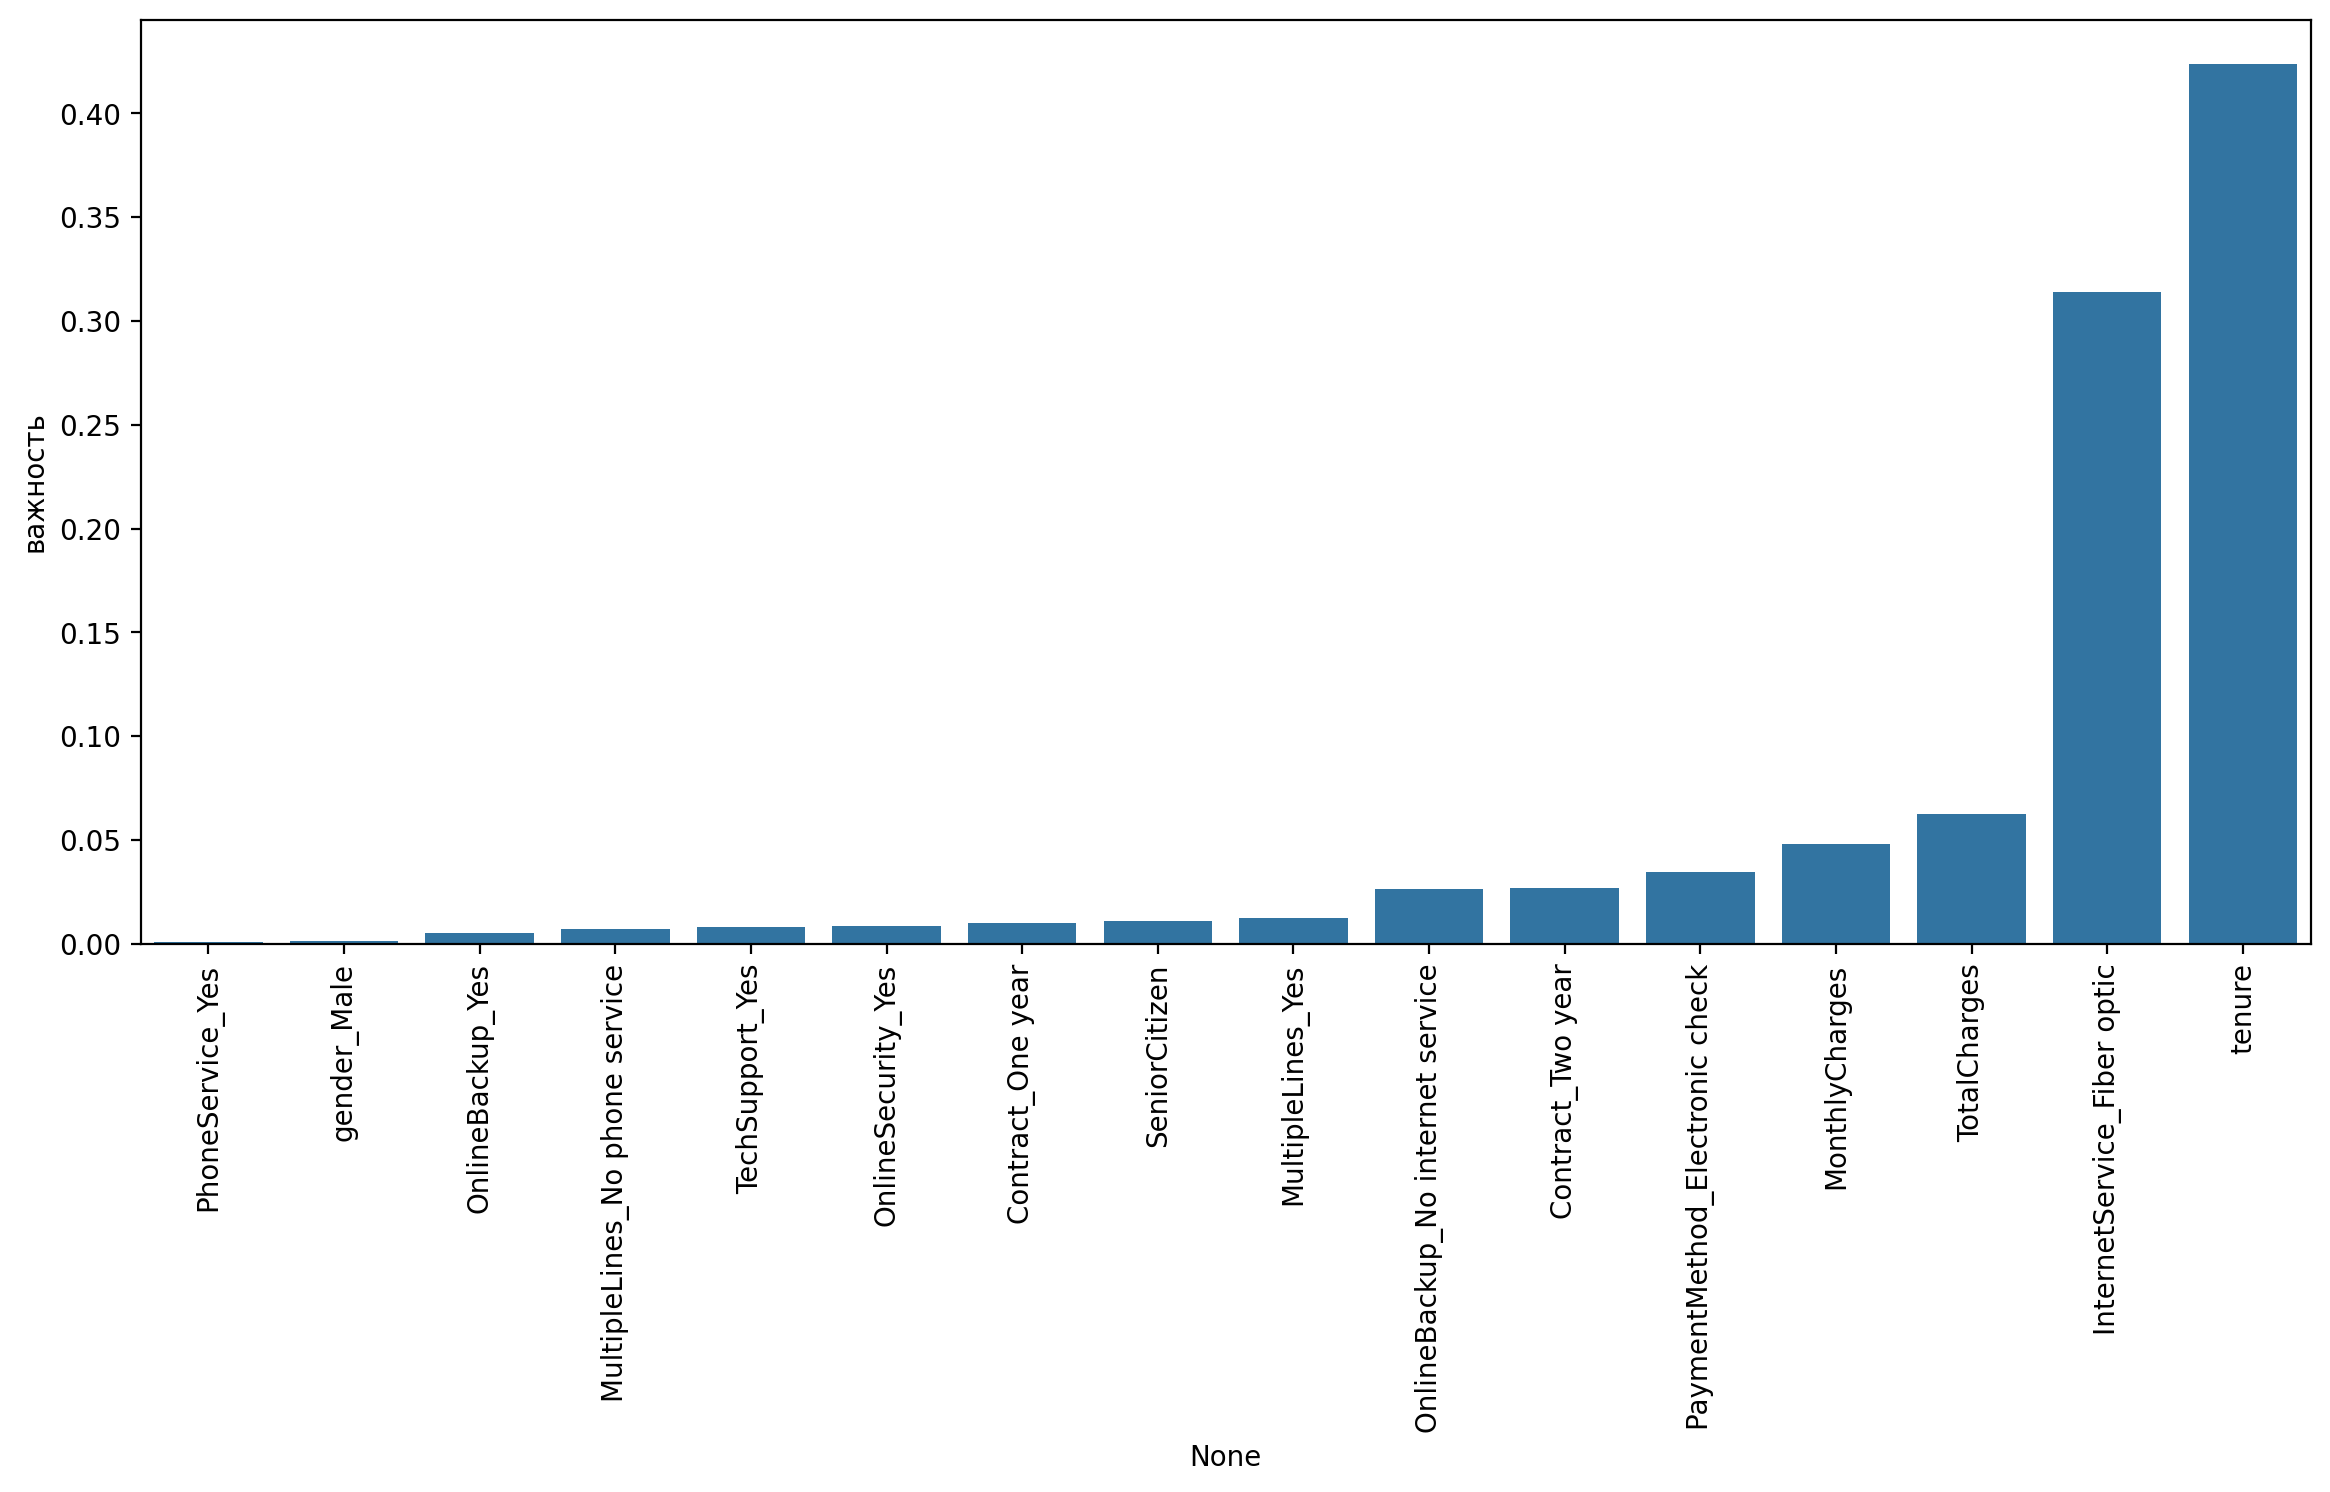

In [157]:
plt.figure(figsize=(14, 6), dpi=200)
sns.barplot(data=imp_feats, x=imp_feats.index, y='важность')
plt.xticks(rotation=90);

С точки зрения этой модели наиболее важные признаки - это tenure (хорошо крппелирует в целевой переменной) и InternetService_Fiber optic (оптоволоконный интернет). Признак tenure мы уже рассмотрели ранее, а InternetService_Fiber optic нужно выяснять причины у провайдера. Почему люди, полузьющиеся оптоволокном уходят в отток?

In [158]:
from sklearn.tree import plot_tree

[Text(0.48522727272727273, 0.9285714285714286, 'x[1] <= 17.5\ngini = 0.396\nsamples = 6328\nvalue = [4606.0, 1722.0]'),
 Text(0.2375, 0.7857142857142857, 'x[10] <= 0.5\ngini = 0.497\nsamples = 2387\nvalue = [1287, 1100]'),
 Text(0.36136363636363633, 0.8571428571428572, 'True  '),
 Text(0.1340909090909091, 0.6428571428571429, 'x[1] <= 5.5\ngini = 0.412\nsamples = 1343\nvalue = [954, 389]'),
 Text(0.07272727272727272, 0.5, 'x[14] <= 0.5\ngini = 0.482\nsamples = 696\nvalue = [414, 282]'),
 Text(0.03636363636363636, 0.35714285714285715, 'x[0] <= 0.5\ngini = 0.5\nsamples = 421\nvalue = [207, 214]'),
 Text(0.01818181818181818, 0.21428571428571427, 'x[2] <= 55.225\ngini = 0.499\nsamples = 370\nvalue = [194, 176]'),
 Text(0.00909090909090909, 0.07142857142857142, 'gini = 0.5\nsamples = 298\nvalue = [145, 153]'),
 Text(0.02727272727272727, 0.07142857142857142, 'gini = 0.435\nsamples = 72\nvalue = [49, 23]'),
 Text(0.05454545454545454, 0.21428571428571427, 'x[2] <= 29.175\ngini = 0.38\nsamples =

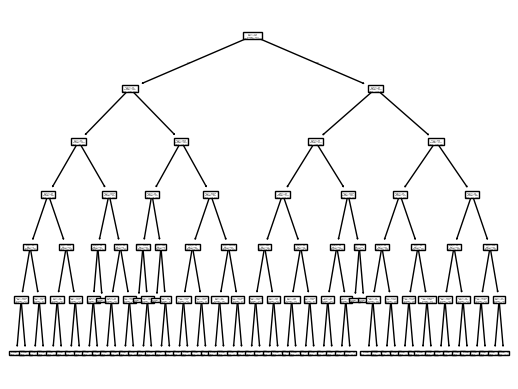

In [159]:
plot_tree(dt)

**Построим модель случайного леса (Random Forest)**

In [160]:
from sklearn.ensemble import RandomForestClassifier

In [161]:
rf = RandomForestClassifier()

In [ ]:
rf.fit(X_train, y_train)

In [163]:
preds = rf.predict(X_test)

In [164]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

          No       0.86      0.88      0.87       557
         Yes       0.50      0.45      0.47       147

    accuracy                           0.79       704
   macro avg       0.68      0.67      0.67       704
weighted avg       0.78      0.79      0.79       704



Эта модель работает хуже, чем дерево решений. Результаты плохие. Попробуем ограничить глубину деревьев.

In [165]:
rf = RandomForestClassifier(max_depth=6)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

In [166]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

          No       0.87      0.92      0.89       557
         Yes       0.61      0.48      0.54       147

    accuracy                           0.83       704
   macro avg       0.74      0.70      0.72       704
weighted avg       0.82      0.83      0.82       704



Результаты улучшились, но всё еще не очень хорошие.

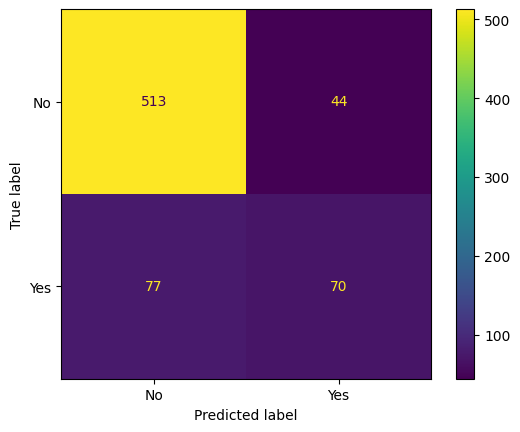

In [167]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.show()

Несмотря на метрики мы не смогли минимизировать метрику recall (81). Она увеличилась с 75 до 81.

**Модель расширяемых деревьев (Boosted Trees)**

In [168]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [169]:
ada_model = AdaBoostClassifier()
gb_model = GradientBoostingClassifier()

In [ ]:
ada_model.fit(X_train, y_train)

In [171]:
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [172]:
ada_preds = ada_model.predict(X_test)
gb_preds = gb_model.predict(X_test)

In [173]:
print(classification_report(y_test, ada_preds))

              precision    recall  f1-score   support

          No       0.88      0.90      0.89       557
         Yes       0.60      0.54      0.57       147

    accuracy                           0.83       704
   macro avg       0.74      0.72      0.73       704
weighted avg       0.82      0.83      0.83       704



In [174]:
print(classification_report(y_test, gb_preds))

              precision    recall  f1-score   support

          No       0.87      0.90      0.89       557
         Yes       0.57      0.50      0.53       147

    accuracy                           0.82       704
   macro avg       0.72      0.70      0.71       704
weighted avg       0.81      0.82      0.81       704



Результаты двух моделей похожи. 

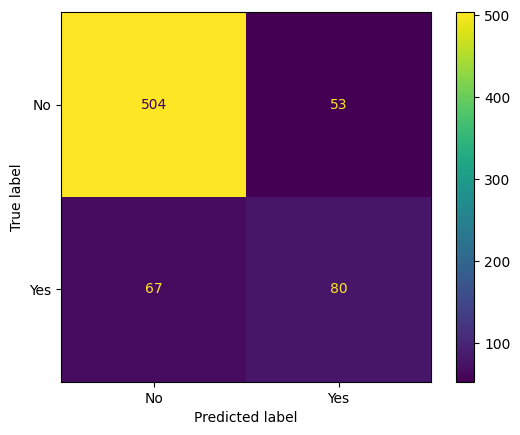

In [175]:
ConfusionMatrixDisplay.from_estimator(ada_model, X_test, y_test)
plt.show()

Модель AdaBoosting работает лучше других и ей удалось снизить значение с 75 до 67, но результаты всё-равно не хорошие. Попробуем поменять параметры модели.

In [176]:
ada_model = AdaBoostClassifier(n_estimators=70)

In [ ]:
ada_model.fit(X_train, y_train)

In [178]:
ada_preds = ada_model.predict(X_test)

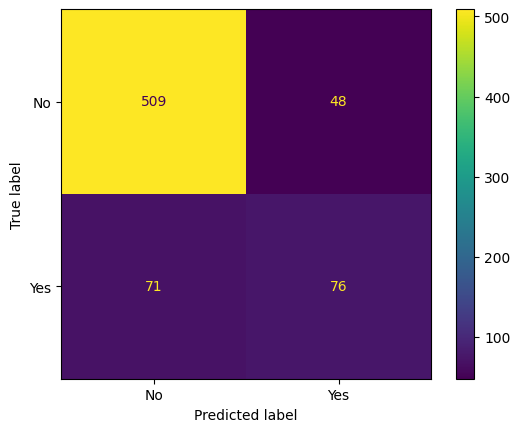

In [179]:
ConfusionMatrixDisplay.from_estimator(ada_model, X_test, y_test)
plt.show()

Результаты стали хуже с 70 и 100 деревьями. С 50 деревьями (значение по умолчанию) результаты были лучше всех.

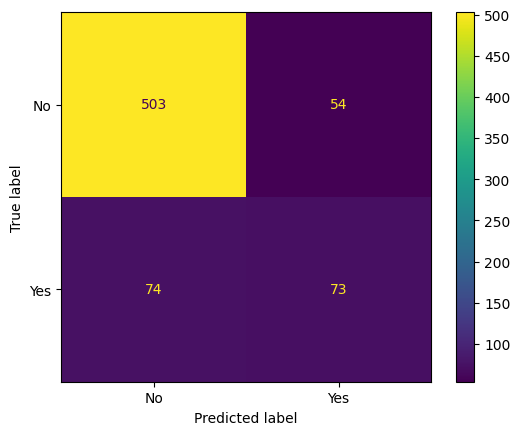

In [180]:
ConfusionMatrixDisplay.from_estimator(gb_model, X_test, y_test)
plt.show()

Наилучшей моделью оказался адаптивный бустинг с параметрами по умолчанию. 

В даннос задаче следует рассмотреть другие методы, например опорных векторов или логистическую регрессию или провести работу с данными совместно с экспертом (feature engineering)